In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border
from skimage import measure
from skimage.measure import label,regionprops
from scipy import ndimage as ndi
from skimage.filters import roberts, sobel
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.morphology import binary_dilation, binary_opening, convex_hull_image
from scipy.ndimage import measurements, center_of_mass, binary_dilation,zoom
from tqdm import tqdm
import os
import glob
from skimage.io import imread

In [2]:
## Doing segmentation of the lungs

## Removing the other body organs from image

#### At the next step we would like to clean up the 3d array of CT Scan, because we like to tell our neural network to pay attention to really important parts, and not to get lost looking at a large amount of unnecessary information.

#### To reach this, we will go through these steps:

1) Convert the original 3d image into a binary image. <br/>

2) Remove the blobs connected to the border of the image. <br/>

3)  Label the connected points of the image. <br/>

4)  Keep the labels with 3 largest areas and segment two lungs and table if present. <br/>

5)  Fill in the small holes inside the mask of lungs which we separate right and left lung. <br/>

6)  Fill the convex hull of each lung. <br/>

7)  Joint two separated right and left lungs.<br/>

 8)  Closure operation with a disk of radius 10. This operation is to keep nodules attached to the lung wall. <br/>

 9) Superimpose the binary mask on the input image.<br/>

In [3]:
#In summary, we segment lungs and make a mask from them, then throw away the voxels out of that mask at the original image.

In [4]:
def get_segmented_lungs(img):
    '''
    This function segments the lungs from the given 2D slice.
    '''
#     plt_number = 0
#     f, plots = plt.subplots(12, 1, figsize=(10, 40))
#     plots[plt_number].imshow(img, cmap=plt.cm.bone)
#     plt_number += 1
    # Step 1: Convert into a binary image.
    binary_img = img < -300
#     plots[plt_number].imshow(binary_img,cmap=plt.cm.bone)
#     plt_number +=1
    
     # Step 2: Remove the blobs connected to the border of the image.
    cleared_img = clear_border(binary_img)
#     plots[plt_number].imshow(cleared_img,cmap=plt.cm.bone)
#     plt_number +=1
     
    # Step 3: Label the image.
    label_img = label(cleared_img)
#     plots[plt_number].imshow(label_img,cmap=plt.cm.bone)
#     plt_number +=1
    
    # Step 4: Keep the labels with 3 largest areas and segment two lungs and the table.
    rps=regionprops(label_img)
    areas = [r.area for r in rps]
    idx = np.argsort(areas)[::-1]#sort largest to smallest
    new_areas = np.zeros_like(label_img)
    for i in idx[:3]:
        new_areas[tuple(rps[i].coords.T)] = i+1
#     plots[plt_number].imshow(new_areas,cmap=plt.cm.bone)
#     plt_number +=1
    
    # Step 5: Fill in the small holes inside the mask of lungs which we seperate right, left lung and table.
    binary_img_label = new_areas>0
    fill_hole_img = ndi.binary_fill_holes(binary_img_label)
#     plots[plt_number].imshow(fill_hole_img,cmap=plt.cm.bone)
#     plt_number +=1
    
    #Step 6:removing table from the whole image
    new_labels = label(fill_hole_img,background=0)
    new_slice = fill_hole_img.copy()
    idx=np.unique(new_labels)[1:]
    comass_y= np.array([center_of_mass(new_labels==i)[0] for i in idx])
    for idxx,com_y in zip(idx,comass_y):
        if(com_y > 0.8*fill_hole_img.shape[0]):
            new_slice[new_labels==idxx]=0
#     plots[plt_number].imshow(new_slice,cmap=plt.cm.bone)
#     plt_number +=1
    
    #Step 7:removing trachea from the whole image
    without_trachea_img = new_slice.copy()
    labels = label(new_slice,connectivity=1,background=0)
    rps=regionprops(labels)
    areas = np.array([r.area for r in rps])
    idx= np.where(areas/512**2 < 0.007)[0]
    for i in idx:
        without_trachea_img[tuple(rps[i].coords.T)]=0
    
    #Step 8:expanding the area of the lungs using convex hull
    new_labels = label(without_trachea_img,background=0)
    larger_area_lung = new_labels == 1
    larger_area_lung = convex_hull_image(larger_area_lung)
    smaller_area_lung = new_labels == 2
    smaller_area_lung = convex_hull_image(smaller_area_lung)
#     plots[plt_number].imshow(larger_area_lung,cmap=plt.cm.bone)
#     plt_number +=1
#     plots[plt_number].imshow(smaller_area_lung,cmap=plt.cm.bone)
#     plt_number +=1

    # Step 9: joint two separated right and left lungs.
    sum_of_lungs = larger_area_lung+ smaller_area_lung
#     plots[plt_number].imshow(sum_of_lungs,cmap=plt.cm.bone)
#     plt_number +=1
    
    # Step 10: Closure operation with a disk of radius 10. This operation is
    # to keep nodules attached to the lung wall.
    selem = disk(10)
    final_operation = binary_closing(sum_of_lungs, selem)
#     plots[plt_number].imshow(final_operation ,cmap=plt.cm.bone)
#     plt_number +=1
    
    # Step 11: Superimpose the binary mask on the input image.
    get_high_vals = final_operation == 0
    img[get_high_vals] = 0
#     plots[plt_number].imshow(img, cmap=plt.cm.bone)

    return img    

## Normalizing the image

In [5]:
# We don't need a big range of voxel values(density HU) for lungs. "http://radclass.mudr.org/content/hounsfield-units-scale-hu-ct-numbers"

##### 
We make a bonding on voxel values to be inside [-1200.0, 600.0] and if it was out of the bounding, it would be decreased or increased to be equal to 600 or -1200.
Then we will scale values to be inside [0.0, 255.0].

In [6]:
def normalize(image):
        MIN_BOUND = -1200
        MAX_BOUND = 600.
        image2 = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
        image2[image2 > 1] = 1.
        image2[image2 < 0] = 0.
        image2 *= 255.
        return image2

In [7]:
input_path = "dataset/2d_slices/imgs/"
output_path_images_png = "dataset/2d_slices/pre_processed_images"
image_files = os.listdir(input_path)
for i in image_files:
    imgs = np.load(input_path+i)
    segmented_image = get_segmented_lungs(imgs)
    img_normal = normalize(segmented_image)
    name = os.path.split(i)
    #print(name[1])
    np.save(os.path.join(output_path_images_png, name[1]), img_normal)
    

C:\ProgramData\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:65: UserWarning: Input image is entirely zero, no valid convex hull. Returning empty image


In [8]:
def display_get_segmented_lungs(img):
    '''
    This function segments the lungs from the given 2D slice.
    '''
    plt_number = 0
    f, plots = plt.subplots(12, 1, figsize=(10, 40))
    plots[plt_number].imshow(img, cmap=plt.cm.bone)
    plt_number += 1
    # Step 1: Convert into a binary image.
    binary_img = img < -300
    plots[plt_number].imshow(binary_img,cmap=plt.cm.bone)
    plt_number +=1
    
     # Step 2: Remove the blobs connected to the border of the image.
    cleared_img = clear_border(binary_img)
    plots[plt_number].imshow(cleared_img,cmap=plt.cm.bone)
    plt_number +=1
     
    # Step 3: Label the image.
    label_img = label(cleared_img)
    plots[plt_number].imshow(label_img,cmap=plt.cm.bone)
    plt_number +=1
    
    # Step 4: Keep the labels with 3 largest areas and segment two lungs and the table.
    rps=regionprops(label_img)
    areas = [r.area for r in rps]
    idx = np.argsort(areas)[::-1]#sort largest to smallest
    new_areas = np.zeros_like(label_img)
    for i in idx[:3]:
        new_areas[tuple(rps[i].coords.T)] = i+1
    plots[plt_number].imshow(new_areas,cmap=plt.cm.bone)
    plt_number +=1
    
    # Step 5: Fill in the small holes inside the mask of lungs which we seperate right, left lung and table.
    binary_img_label = new_areas>0
    fill_hole_img = ndi.binary_fill_holes(binary_img_label)
    plots[plt_number].imshow(fill_hole_img,cmap=plt.cm.bone)
    plt_number +=1
    
    #Step 6:removing table from the whole image
    new_labels = label(fill_hole_img,background=0)
    new_slice = fill_hole_img.copy()
    idx=np.unique(new_labels)[1:]
    comass_y= np.array([center_of_mass(new_labels==i)[0] for i in idx])
    for idxx,com_y in zip(idx,comass_y):
        if(com_y > 0.8*fill_hole_img.shape[0]):
            new_slice[new_labels==idxx]=0
    plots[plt_number].imshow(new_slice,cmap=plt.cm.bone)
    plt_number +=1
    
    #Step 7:removing trachea from the whole image
    without_trachea_img = new_slice.copy()
    labels = label(new_slice,connectivity=1,background=0)
    rps=regionprops(labels)
    areas = np.array([r.area for r in rps])
    idx= np.where(areas/512**2 < 0.007)[0]
    for i in idx:
        without_trachea_img[tuple(rps[i].coords.T)]=0
    
    #Step 8:expanding the area of the lungs using convex hull
    new_labels = label(without_trachea_img,background=0)
    larger_area_lung = new_labels == 1
    larger_area_lung = convex_hull_image(larger_area_lung)
    smaller_area_lung = new_labels == 2
    smaller_area_lung = convex_hull_image(smaller_area_lung)
    plots[plt_number].imshow(larger_area_lung,cmap=plt.cm.bone)
    plt_number +=1
    plots[plt_number].imshow(smaller_area_lung,cmap=plt.cm.bone)
    plt_number +=1

    # Step 9: joint two separated right and left lungs.
    sum_of_lungs = larger_area_lung+ smaller_area_lung
    plots[plt_number].imshow(sum_of_lungs,cmap=plt.cm.bone)
    plt_number +=1
    
    # Step 10: Closure operation with a disk of radius 10. This operation is
    # to keep nodules attached to the lung wall.
    selem = disk(10)
    final_operation = binary_closing(sum_of_lungs, selem)
    plots[plt_number].imshow(final_operation ,cmap=plt.cm.bone)
    plt_number +=1
    
    # Step 11: Superimpose the binary mask on the input image.
    get_high_vals = final_operation == 0
    img[get_high_vals] = 0
    plots[plt_number].imshow(img, cmap=plt.cm.bone)
    return img 

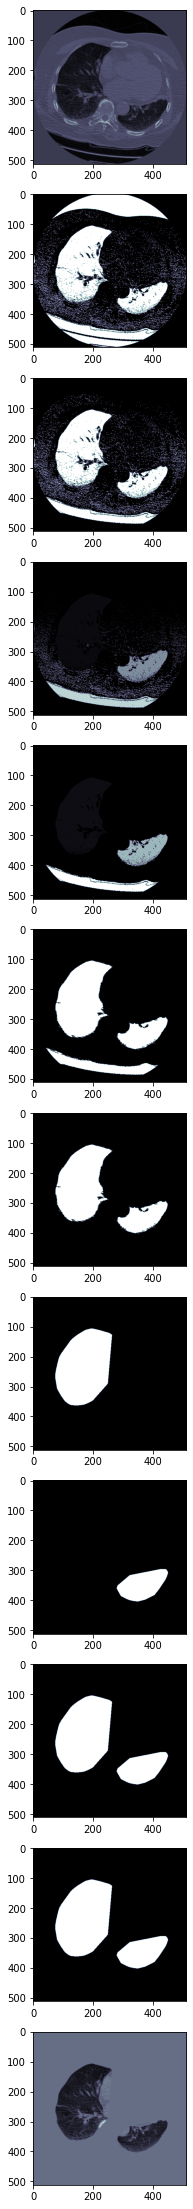

In [9]:
input_path = "dataset/2d_slices/imgs/"
imgs = np.load(input_path+'images_1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059_57.npy')
segmented_image = display_get_segmented_lungs(imgs)


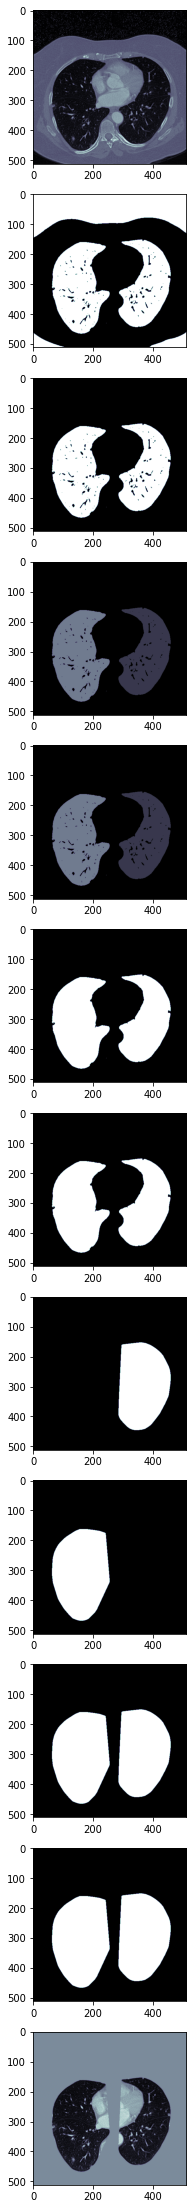

In [10]:
input_path = "dataset/2d_slices/imgs/"
imgs = np.load(input_path+'images_1.3.6.1.4.1.14519.5.2.1.6279.6001.107351566259572521472765997306_114.npy')
segmented_image = display_get_segmented_lungs(imgs)
